# DCT example
taken from https://inst.eecs.berkeley.edu/~ee123/sp16/Sections/JPEG_DCT_Demo.html


In [81]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.fftpack
from skimage import data, io, filters
from scipy import ndimage

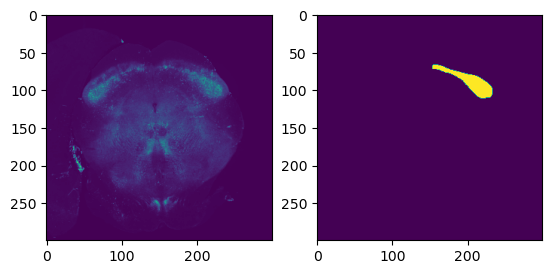

In [316]:
im = io.imread('/home/jeromeb/Desktop/img.tif')
label = io.imread('/home/jeromeb/Desktop/Labeling.tif')
im = im[150:450,200:500]
label = label[150:450,200:500]
#im = np.concatenate([im,np.flip(im,1)])
#label = np.concatenate([label,np.flip(label,1)])
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(label>85)

im = im.reshape([1, *im.shape])

In [3]:

def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')



In [83]:
# Do 8x8 DCT on image (in-place)
n = 8
dct = np.zeros(im.shape)
for i in np.r_[:im.shape[0]:n]:
    for j in np.r_[:im.shape[1]:n]:
        dct[i:(i+n),j:(j+n)] = dct2( im[i:(i+n),j:(j+n)] )

In [87]:
np.array(im.shape) // 8

array([37, 48])

In [ ]:
np.array(im.shape) // 8

ValueError: cannot reshape array of size 116352 into shape (64,37,48)

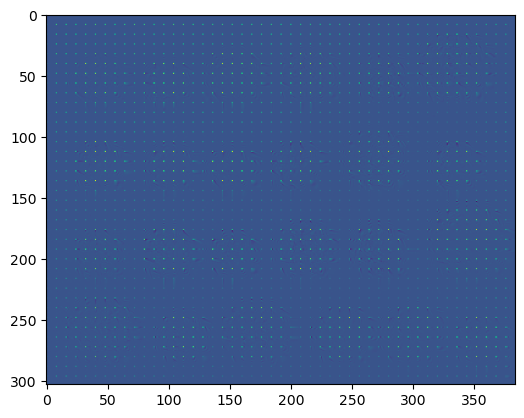

In [86]:
plt.imshow(dct)
dct.reshape((n*n,dct.shape[0]//n,dct.shape[1]//n))

In [92]:
M = np.zeros((3,3,5))
M[1,1] = 1
M

array([[[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]]])

In [109]:
n = 10
stride = 2
block_size = 4
print((n - block_size) / stride)
np.arange(0,n - block_size, stride)
np.r_[:n - block_size: stride]


3.0


array([0, 2, 4])

In [122]:
im[block_size*i:block_size*(i+1), block_size*j:block_size*(j+1)].shape
block_size*j

384

In [145]:
for i in np.arange(dct.shape[0]):
    print(i,stride*i,stride*i+block_size)

0 0 8
1 2 10
2 4 12
3 6 14
4 8 16
5 10 18
6 12 20
7 14 22
8 16 24
9 18 26
10 20 28
11 22 30
12 24 32
13 26 34
14 28 36
15 30 38
16 32 40
17 34 42
18 36 44
19 38 46
20 40 48
21 42 50
22 44 52
23 46 54
24 48 56
25 50 58
26 52 60
27 54 62
28 56 64
29 58 66
30 60 68
31 62 70
32 64 72
33 66 74
34 68 76
35 70 78
36 72 80
37 74 82
38 76 84
39 78 86
40 80 88
41 82 90
42 84 92
43 86 94
44 88 96
45 90 98
46 92 100
47 94 102
48 96 104
49 98 106
50 100 108
51 102 110
52 104 112
53 106 114
54 108 116
55 110 118
56 112 120
57 114 122
58 116 124
59 118 126
60 120 128
61 122 130
62 124 132
63 126 134


In [166]:
#im = np.moveaxis(im,2,0).reshape([1,512,512])
im = np.reshape(im,[1,*im.shape])

In [309]:
def dct2D(im, in_channels, out_channels, block_size, stride):
    NC = block_size*block_size
    shape = (out_channels, *((np.array(im.shape[1:])-block_size) // stride))        
    dst = np.zeros(shape)    
    for i in range(dst.shape[1]):
        for j in range(dst.shape[2]):
            v = np.zeros(out_channels)
            for c in range(in_channels):
                block = im[c, stride*i:stride*i+block_size, stride*j:stride*j+block_size]
                for a in range(2):
                    block = scipy.fftpack.dct(block, axis = a, norm='ortho')
                v = v + block.ravel()[0:out_channels]            
            dst[:,i,j] = v
#            dst[:,i,j] = dct2( im[stride*i:stride*i+block_size, stride*j:stride*j+block_size] ).ravel()
    return dst

depth = 1
L = [dct2D(im,1,8,8,4)]
for k in range(depth):
    L.append(dct2D(L[k],8,8,8,4))

# upscale each level
for k in range(len(L)):    
    L[k] = ndimage.zoom(L[k],[1, im.shape[1]/L[k].shape[1], im.shape[2]/L[k].shape[2]])

X = np.concatenate(L,axis=0)
print(X.shape)


(16, 600, 300)


(10415, 32) (10415,)
Accuracy: 0.994 (0.002)


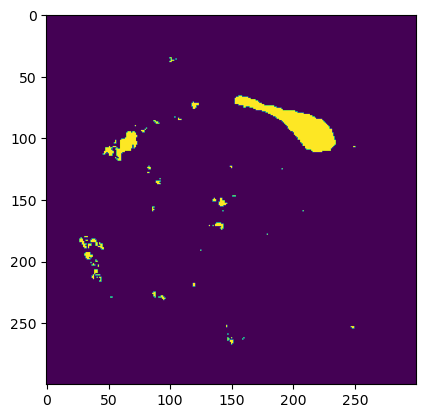

In [378]:
# compute features
depth = 0
im = (im - im.mean())/im.std()
L = [dct2D(im,1,32,8,4)]
for k in range(depth):    
    L.append(dct2D(L[k],L[k].shape[0],32,8,2))

# re scale each level
for k in range(len(L)):    
    L[k] = ndimage.zoom(L[k],[1, im.shape[1]/L[k].shape[1], im.shape[2]/L[k].shape[2]])
    L[k] = (L[k] - L[k].mean()) / L[k].std()

X = np.concatenate(L,axis=0)

# fit a model
xx = X[:,label > 0].T
yy = label[label > 0] > 86

print(xx.shape,yy.shape)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model = RandomForestClassifier(max_features=10)

model.fit(xx, yy)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, xx, yy, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# predict
yhat = model.predict(X.reshape((X.shape[0],-1)).T)
plt.imshow(yhat.reshape(im.shape)[0])

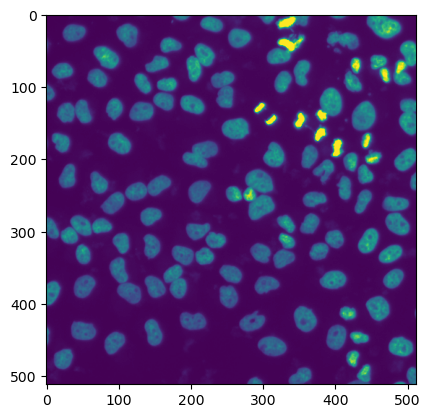

In [133]:
plt.imshow(im[0])

# Filter bank features

Compute features from an image and apply an random forest classifier to
classify pixels

In [455]:
%matplotlib ipympl
import matplotlib.cbook as cbook
import matplotlib.pyplot as plt
import numpy as np
from mpl_interactions import image_segmenter

In [456]:
segmenter = image_segmenter(im[0], nclasses=2, mask_colors="red", mask_alpha=0.76, figsize=(7, 7))
display(segmenter)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [453]:
plt.imshow(segmenter.mask)


Accuracy: 0.996 (0.002)


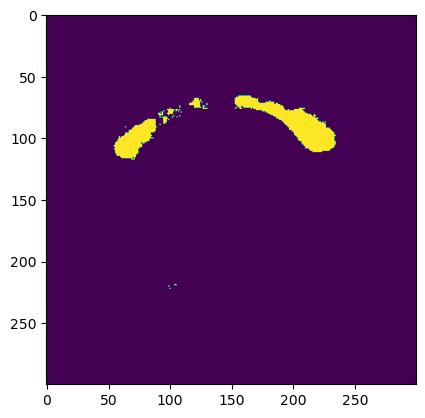

In [448]:
def compute_features(image):    
    feat1 = np.diff(np.stack([ndimage.gaussian_filter(image, s) for s in np.geomspace(1, 16, 5)]),1,0)
    feat2 = np.stack([ndimage.grey_dilation(image, int(s)) for s in np.geomspace(1, 16, 5)])
    feat3 = np.stack([ndimage.grey_erosion(image, int(s)) for s in np.geomspace(1, 16, 5)])
    return np.concatenate([feat1,feat2,feat3],axis=0)

feat = compute_features(im[0])
feat.shape
X = feat[:,label > 0].T
y = label[label > 0] > 86
model = RandomForestClassifier()
model.fit(X, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
yhat = model.predict(feat.reshape((feat.shape[0],-1)).T)
plt.imshow(yhat.reshape(im.shape)[0]);


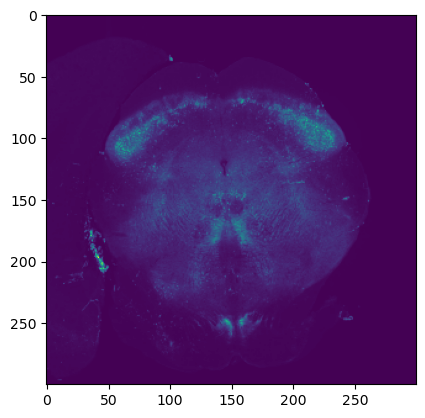

In [449]:
plt.imshow(im[0])